### Objetivo
Desenvolver, treinar e avaliar modelos preditivos para estimar a probabilidade da variável target (y), utilizando os dados pré-processados no Notebook 2. A modelagem respeita a separação temporal dos dados e avalia o desempenho por meio de métricas adequadas a problemas de crédito.

In [1]:
import sys
import os

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(ROOT_DIR)

import pandas as pd
import numpy as np

from src.modelagem import compute_metrics
from src.modelagem import psi_por_variavel_com_coef
from src.modelagem import psi_score

from src.modelagem import psi_por_safra

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt
import seaborn as sns


#### #1 Importação dos dados
Nesta etapa são importados os datasets de treino, validação e teste previamente processados no Notebook 2, garantindo consistência e reprodutibilidade no fluxo de modelagem.

In [2]:
# Treino
df_treino_mediana_base = pd.read_csv('../data/processed/treino_mediana.csv')

# Validação
df_validacao_mediana_base = pd.read_csv('../data/processed/validacao_mediana.csv')

# Teste
df_teste_mediana_base = pd.read_csv('../data/processed/teste_mediana.csv')



#### #2 Treinamento do modelo
Nesta etapa é realizado o treinamento de um modelo base de Regressão Logística, escolhido por sua ampla utilização em problemas de credit scoring, devido à sua interpretabilidade, estabilidade e facilidade de governança.

O modelo foi treinado utilizando os seguintes parâmetros:

- max_iter = 2000<br>
- penalty = "l2"<br>
- random_state = 42<br>

A regularização L2 foi adotada com o objetivo de reduzir overfitting<br> 
O parâmetro max_iter foi definido como 2000 para garantir a convergência do algoritmo, evitando interrupções prematuras do processo de otimização<br>
O uso de random_state = 42 assegura a reprodutibilidade dos resultados, permitindo que o treinamento do modelo produza os mesmos coeficientes em execuções futuras.<br><br>

In [3]:
X_train_base = df_treino_mediana_base.drop(columns=['y', 'safra', 'id'])
y_train_base = df_treino_mediana_base['y']

X_val_base = df_validacao_mediana_base.drop(columns=['y', 'safra', 'id'])
y_val_base = df_validacao_mediana_base['y']

X_teste_base = df_teste_mediana_base.drop(columns=['y', 'safra', 'id'])
y_teste_base = df_teste_mediana_base['y']


In [4]:
modelo_base = LogisticRegression(
    max_iter=2000,
    random_state=42,
    penalty='l2'
)

modelo_base.fit(X_train_base, y_train_base)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` p

Nesta etapa são salvas as probabilidades previstas pelo modelo e calculadas as métricas de desempenho, dando continuidade à análise dos resultados. Serão avaliadas as métricas AUC, KS e Gini, com o objetivo de mensurar a capacidade de separação e o poder preditivo do modelo.

Em seguida, é realizada a análise de estabilidade das variáveis e do modelo nas bases de validação e teste, permitindo a identificação de possíveis instabilidades temporais. Com base nessa análise, avalia-se a necessidade de remoção de variáveis excessivamente instáveis, buscando um equilíbrio entre desempenho e robustez do modelo.

In [5]:
y_train_score_base = modelo_base.predict_proba(X_train_base)[:, 1]
y_valid_score_base = modelo_base.predict_proba(X_val_base)[:, 1]
y_teste_score_base  = modelo_base.predict_proba(X_teste_base)[:, 1]

df_metricas_base = pd.DataFrame(
    {
        "Treino": compute_metrics(y_train_base, y_train_score_base),
        "Validação": compute_metrics(y_val_base, y_valid_score_base),
        "Teste": compute_metrics(y_teste_base, y_teste_score_base),
    }
).T

In [6]:
var_psi_valid_base = psi_por_variavel_com_coef(X_train_base, X_val_base, modelo_base, bins=10)
var_psi_teste_base  = psi_por_variavel_com_coef(X_train_base, X_teste_base, modelo_base,  bins=10)

psi_score_valid = psi_score(y_train_score_base, y_valid_score_base, bins=10)
psi_score_test  = psi_score(y_train_score_base, y_teste_score_base,  bins=10)

#### #3 Avaliação do modelo
Nesta etapa é realizada a análise dos coeficientes do modelo e do Population Stability Index (PSI) das variáveis, com o objetivo de apoiar o ajuste fino do modelo.

As variáveis que apresentam valores de PSI superiores a 0,20 são analisadas com maior atenção, uma vez que esse patamar pode indicar instabilidade temporal relevante. Nessas situações, avalia-se a possibilidade de exclusão da variável, considerando conjuntamente seu impacto no desempenho do modelo e sua importância preditiva.

In [7]:
var_psi_teste_base.T

,VAR_53,VAR_54,VAR_30,VAR_1,VAR_9,VAR_20,VAR_4,VAR_65,VAR_5,VAR_3,...,VAR_72,VAR_6,VAR_2,VAR_58,VAR_32,VAR_24,VAR_28,VAR_40,VAR_64,VAR_19
PSI,1.058077,0.403143,0.387795,0.216453,0.029952,0.027673,0.023268,0.015177,0.012540,0.011457,...,0.008041,0.007865,0.005983,0.005762,0.005728,0.005676,0.003404,0.003305,0.001920,0.001850
coeficiente,-0.219085,-0.106619,-0.237186,-1.096325,-1.016982,-0.763449,-0.015128,-0.161543,0.119927,0.212895,...,0.402682,-0.142722,0.470856,-0.156270,-0.352927,-0.635240,-0.048598,0.014576,0.218992,-0.182664


A avaliação conjunta do PSI e dos coeficientes do modelo permitiu as seguintes conclusões:<br>

Avaliando cada uma delas pelo PSI e coeficiente, podemos concluir<br>
- VAR_53: apresentou PSI muito elevado, indicando uma mudança significativa na população entre as bases de treino e teste. Dado o alto nível de instabilidade, o critério adotado foi a remoção da variável.<br>
- VAR_54: apresentou PSI elevado, indicando instabilidade temporal, além de baixa relevância no modelo. Dessa forma, optou-se pela remoção da variável.<br>
- VAR_30: apresentou comportamento semelhante, com PSI elevado além de também baixa relevância para o modelo. Nesse caso o critério foi o mesmo adotado para a variável VAR_54.<br>
- VAR_1: apresentou PSI levemente elevado, porém com forte relevância preditiva. Nesse caso, o critério adotado foi também a manutenção da variável no modelo, com recomendação de monitoramento contínuo em produção.<br>


#### #4 Ajuste fino do modelo
Nesta etapa é realizado o ajuste fino do modelo por meio da remoção das variáveis previamente identificadas como instáveis ou pouco relevantes, com o objetivo de melhorar a robustez, a estabilidade temporal e a qualidade geral do modelo.

In [8]:
# Treino
df_treino_mediana_refinado = df_treino_mediana_base.drop(columns=['VAR_53', 'VAR_54', 'VAR_30'])

# Validação
df_validacao_mediana_refinado = df_validacao_mediana_base.drop(columns=['VAR_53', 'VAR_54', 'VAR_30'])

# # Teste
df_teste_mediana_refinado = df_teste_mediana_base.drop(columns=['VAR_53', 'VAR_54', 'VAR_30'])

In [9]:
X_train_refinado = df_treino_mediana_refinado.drop(columns=['y', 'safra', 'id'])
y_train_refinado = df_treino_mediana_refinado['y']

X_val_refinado = df_validacao_mediana_refinado.drop(columns=['y', 'safra', 'id'])
y_val_refinado = df_validacao_mediana_refinado['y']

X_teste_refinado = df_teste_mediana_refinado.drop(columns=['y', 'safra', 'id'])
y_teste_refinado = df_teste_mediana_refinado['y']

In [10]:
modelo_refinado = LogisticRegression(
    max_iter=2000,
    random_state=42,
    penalty='l2'
)

modelo_refinado.fit(X_train_refinado, y_train_refinado)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass` p

In [11]:
y_train_score_refinado = modelo_refinado.predict_proba(X_train_refinado)[:, 1]
y_valid_score_refinado = modelo_refinado.predict_proba(X_val_refinado)[:, 1]
y_teste_score_refinado  = modelo_refinado.predict_proba(X_teste_refinado)[:, 1]

df_metricas_refinado = pd.DataFrame(
    {
        "Treino": compute_metrics(y_train_refinado, y_train_score_refinado),
        "Validação": compute_metrics(y_val_refinado, y_valid_score_refinado),
        "Teste": compute_metrics(y_teste_refinado, y_teste_score_refinado),
    }
).T

In [12]:
var_psi_valid_refinado = psi_por_variavel_com_coef(X_train_refinado, X_val_refinado, modelo_refinado, bins=10)
var_psi_teste_refinado  = psi_por_variavel_com_coef(X_train_refinado, X_teste_refinado, modelo_refinado,  bins=10)

psi_score_valid = psi_score(y_train_score_refinado, y_valid_score_refinado, bins=10)
psi_score_test  = psi_score(y_train_score_refinado, y_teste_score_refinado,  bins=10)

#### #5 Comparação de modelos
Nesta etapa é realizada a comparação gráfica entre os modelos desenvolvidos, com foco tanto em desempenho quanto em estabilidade. Serão analisados os seguintes aspectos:<br>

- Curva ROC, para avaliação da capacidade de separação<br>
- Distribuição de score por classe, para análise da discriminação entre bons e maus pagadores<br>
- Lift Chart, para avaliação do ganho do modelo em relação a uma seleção aleatória<br>
- Estabilidade do score por safra, visando identificar possíveis degradações temporais<br>
- PSI das variáveis em cada modelo, permitindo comparar a robustez e estabilidade entre as versões<br>

Essa análise conjunta permite selecionar o modelo que apresenta o melhor equilíbrio entre desempenho preditivo, capacidade de discriminação e estabilidade ao longo do tempo. A decisão final do modelo prioriza estabilidade e governança, além de performance.

#### Curva ROC

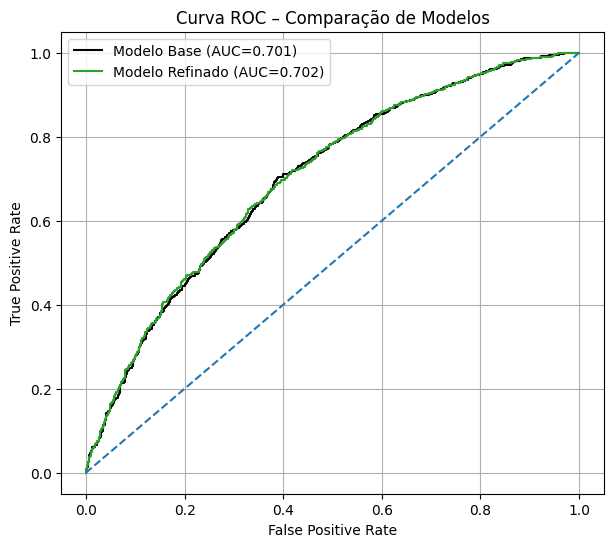

In [13]:
fpr1, tpr1, _ = roc_curve(y_teste_base, y_teste_score_base)
fpr2, tpr2, _ = roc_curve(y_teste_refinado, y_teste_score_refinado)

auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(7,6))
plt.plot(fpr1, tpr1, label=f'Modelo Base (AUC={auc1:.3f})', color='black')
plt.plot(fpr2, tpr2, label=f'Modelo Refinado (AUC={auc2:.3f})', color='tab:green')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC – Comparação de Modelos')
plt.legend()
plt.grid(True)
plt.show()


A comparação das curvas ROC indica uma diferença mínima entre os modelos, sugerindo desempenho preditivo equivalente em termos de capacidade de separação. Diante desse resultado, torna-se necessário avaliar métricas adicionais e aspectos complementares, como estabilidade e discriminação por faixa de score, para embasar a escolha do modelo a ser utilizado.

#### Distribuição de Score por Classe

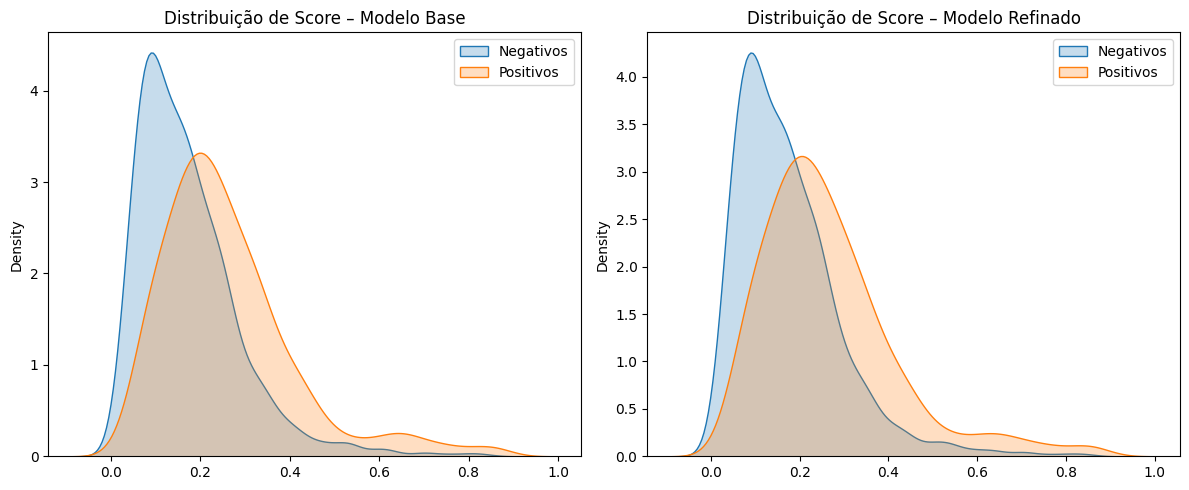

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.kdeplot(y_teste_score_base[y_teste_base==0], ax=axes[0], label='Negativos', fill=True)
sns.kdeplot(y_teste_score_base[y_teste_base==1], ax=axes[0], label='Positivos', fill=True)
axes[0].set_title('Distribuição de Score – Modelo Base')
axes[0].legend()

sns.kdeplot(y_teste_score_refinado[y_teste_refinado==0], ax=axes[1], label='Negativos', fill=True)
sns.kdeplot(y_teste_score_refinado[y_teste_refinado==1], ax=axes[1], label='Positivos', fill=True)
axes[1].set_title('Distribuição de Score – Modelo Refinado')
axes[1].legend()

plt.tight_layout()
plt.show()


A distribuição das observações por faixa de score também se mostra bastante semelhante entre os modelos analisados. Considerando que ambos apresentam desempenho equivalente em termos de AUC e distribuição de scores, a decisão passa a ser orientada por critérios adicionais, principalmente a estabilidade temporal e a interpretabilidade do modelo, fatores fundamentais em contextos de credit scoring.

#### Auc por safra

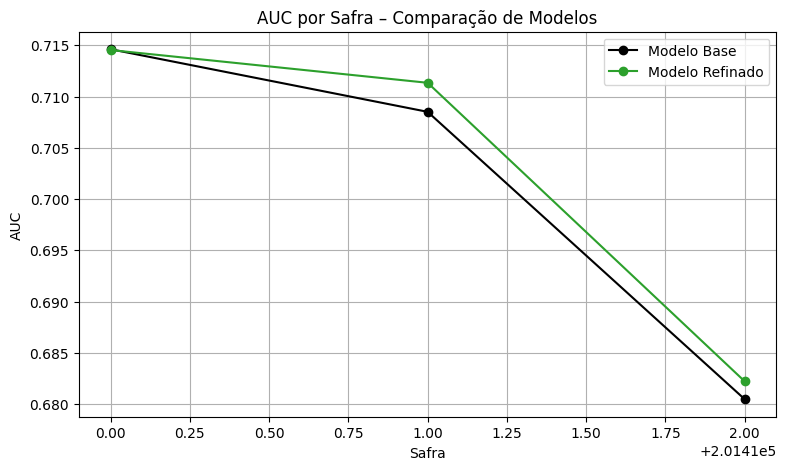

In [15]:
df_eval = df_teste_mediana_base.copy()
df_eval['score_m1'] = y_teste_score_base
df_eval['score_m2'] = y_teste_score_refinado

auc_safra = df_eval.groupby('safra').apply(
    lambda x: pd.Series({
        'Modelo Base': roc_auc_score(x['y'], x['score_m1']),
        'Modelo Refinado': roc_auc_score(x['y'], x['score_m2'])
    })
)

plt.figure(figsize=(9,5))
plt.plot(auc_safra.index, auc_safra['Modelo Base'], marker='o', label='Modelo Base', color='black')
plt.plot(auc_safra.index, auc_safra['Modelo Refinado'], marker='o', label='Modelo Refinado', color='tab:green')
plt.ylabel('AUC')
plt.xlabel('Safra')
plt.title('AUC por Safra – Comparação de Modelos')
plt.legend()
plt.grid(True)
plt.show()


Observa-se que ambos os modelos apresentam uma redução gradual da métrica AUC ao longo das safras, comportamento esperado em modelos de crédito devido à mudança de perfil da população ao longo do tempo. No entanto, o modelo refinado apresenta desempenho levemente superior, mantendo-se aproximadamente um ponto percentual acima do modelo base de forma consistente, o que indica maior estabilidade temporal.

In [16]:
df_teste = df_teste_mediana_base = pd.read_csv('../data/processed/teste_mediana.csv')

df_teste['score_base'] = y_teste_score_base
df_teste['score_refinado'] = y_teste_score_refinado


In [17]:
psi_base = psi_por_safra(df_teste, 'score_base')
psi_refinado = psi_por_safra(df_teste, 'score_refinado')


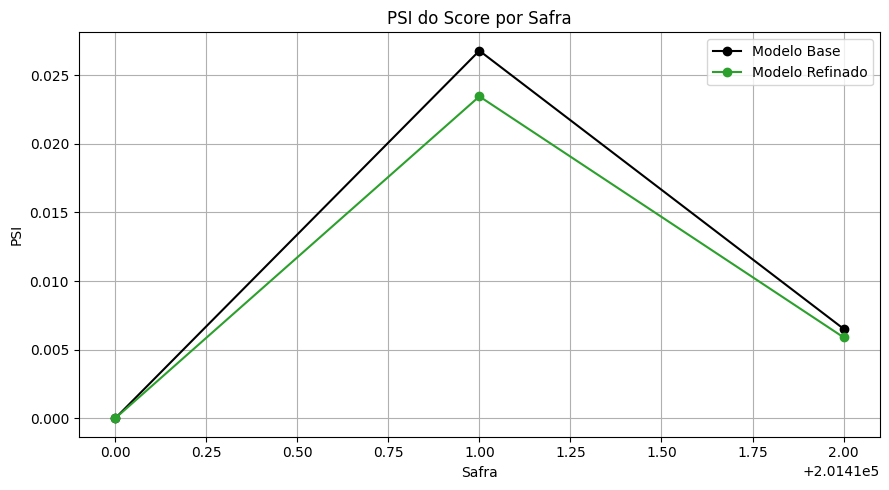

In [18]:
plt.figure(figsize=(9,5))

plt.plot(psi_base.index, psi_base.values, marker='o', label='Modelo Base', color='black')
plt.plot(psi_refinado.index, psi_refinado.values, marker='o', label='Modelo Refinado', color='tab:green')

plt.title('PSI do Score por Safra')
plt.xlabel('Safra')
plt.ylabel('PSI')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Observa-se também que o modelo refinado apresenta valores de PSI aproximadamente três pontos percentuais inferiores aos do modelo base, reforçando sua maior estabilidade temporal. Um PSI mais baixo indica menor deslocamento da distribuição de scores entre as amostras de treino e períodos futuros, característica desejável em modelos de crédito.

#### PSI por variáveis

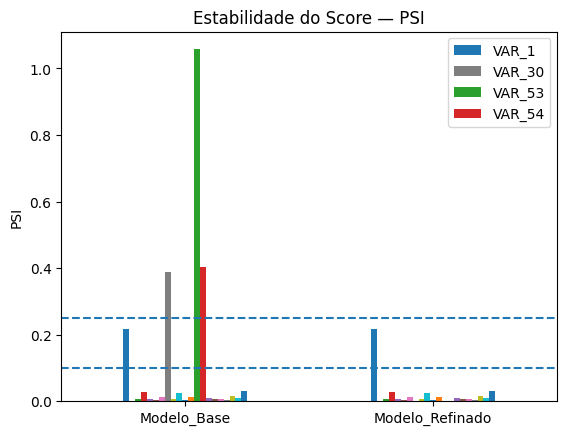

In [19]:
df_psi_score = pd.DataFrame({
    "Modelo_Base": var_psi_teste_base['PSI'],
    "Modelo_Refinado": var_psi_teste_refinado['PSI']
})

ax = df_psi_score.T.plot(kind="bar")

# pega handles e labels da legenda
handles, labels = ax.get_legend_handles_labels()

# dataframe transposto (cada coluna = um modelo)
df_plot = df_psi_score.T

# filtra apenas modelos com PSI > 0.1
handles_filtrados = []
labels_filtrados = []

for handle, label in zip(handles, labels):
    if (df_plot[label] > 0.1).any():
        handles_filtrados.append(handle)
        labels_filtrados.append(label)

ax.legend(handles_filtrados, labels_filtrados)

plt.title("Estabilidade do Score — PSI")
plt.ylabel("PSI")
plt.axhline(0.10, linestyle="--")
plt.axhline(0.25, linestyle="--")
plt.xticks(rotation=0)
plt.show()


Por fim, é apresentada de forma visual a decisão de remoção de variáveis com base na análise de estabilidade. As variáveis VAR_30, VAR_53 e VAR_54 foram removidas do modelo por apresentarem valores de PSI acima do limiar de 0,25, indicando instabilidade significativa ao longo do tempo.

A variável VAR_1, embora apresente um PSI levemente elevado, demonstrou alta relevância para o modelo e, portanto, foi mantida, com recomendação de monitoramento contínuo após a implantação.

#### #6 Considerações finais - Modelagem
Neste notebook foi desenvolvido e avaliado um modelo de credit scoring com foco não apenas na performance preditiva, mas principalmente na estabilidade e robustez, aspectos fundamentais para aplicações em risco de crédito.

Inicialmente, foi treinado um modelo base de Regressão Logística, utilizando imputação por mediana, e avaliado nas bases de treino, validação e teste por meio de métricas tradicionais como AUC e KS. Em paralelo, foi conduzida uma análise detalhada do Population Stability Index (PSI), tanto em nível de variável quanto para o score final, permitindo a avaliação de possíveis mudanças de distribuição entre as populações ao longo do tempo.

A análise de PSI por variável evidenciou a presença de drift relevante em algumas features, especialmente aquelas que combinavam PSI elevado e baixo impacto no modelo, conforme indicado pelos coeficientes da regressão. Com base nesses critérios, foi realizado um processo de fine tuning, removendo variáveis instáveis e re-treinando o modelo.

O modelo refinado apresentou:<br>

- Leve redução nas métricas de performance (AUC e KS), dentro de limites aceitáveis<br>
- Redução do PSI por variável, indicando maior estabilidade<br>
- Pequena melhora no PSI do score, reforçando a robustez do modelo frente a mudanças de população<br>

Diante desses resultados, o modelo refinado foi selecionado como versão final.

Esses achados reforçam um princípio central da modelagem de crédito: a busca pelo equilíbrio entre performance e estabilidade. Modelos ligeiramente menos discriminatórios, porém mais estáveis, tendem a apresentar melhor desempenho em produção e menor risco de degradação ao longo do tempo.